# Quality Complaints Classification

ML model to classify whether a quality complaint is valid or not.

In [29]:
import warnings
import pandas as pd
import category_encoders as ce
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from dython.nominal import associations
from sklearn.model_selection import train_test_split

from helpers import constants

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

## EDA

1. Converting the variables to categorical
2. Drop NA values
3. Summary statistics
4. Histograms
5. Statistical tests
6. Association matrix

In [30]:
df = pd.read_csv('db/dataset-qc.csv', sep=';', usecols=constants.COLUMNS)

In [31]:
df.head()

,brand,hybrid,batch,sieve,treatment,reason,result,quantity,city,state,germination
0,0,0,0,0,0,insect attack,not proceed,20.0,0,MG,98.0
1,0,1,1,1,1,insect attack,not proceed,3.0,1,MS,99.0
2,0,1,2,1,2,insect attack,not proceed,27.0,1,MS,99.0
3,0,2,3,2,2,insect attack,not proceed,382.0,2,MT,99.0
4,0,3,4,3,2,insect attack,not proceed,100.0,2,MT,99.0


In [32]:
for cat_col in constants.CATEGORICAL_COLUMNS:
    df[cat_col] = df[cat_col].astype('category')
df['result'] = df['result'].astype('category')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   brand        2584 non-null   category
 1   hybrid       2584 non-null   category
 2   batch        2584 non-null   category
 3   sieve        2584 non-null   category
 4   treatment    2584 non-null   category
 5   reason       2584 non-null   category
 6   result       2584 non-null   category
 7   quantity     2547 non-null   float64 
 8   city         2584 non-null   category
 9   state        2515 non-null   category
 10  germination  2097 non-null   float64 
dtypes: category(9), float64(2)
memory usage: 175.6 KB


In [34]:
df.dropna(inplace=True)
df.describe()

,quantity,germination
count,2035.000000,2035.000000
mean,98.840295,97.148403
std,156.241680,2.020687
min,0.000000,82.000000
25%,20.000000,96.000000
50%,45.000000,98.000000
75%,108.000000,99.000000
max,1400.000000,100.000000


In [35]:
fig1 = go.Figure(
    go.Bar(
        x=df["result"].value_counts().index,
        y=df["result"].value_counts().values,
        marker={"color": ["#1f77b4", "#d62728"]},
        text=df["result"].value_counts().values,
        textposition="auto",
    ),
)
fig1.update_layout(
    title_text="Histogram of Results", bargap=0.5, width=600, height=400
)
fig1.show()

In [36]:
fig2 = go.Figure(
    go.Bar(
        x=df["reason"].value_counts().index[:3],
        y=df["reason"].value_counts().values[:3],
        text=df["reason"].value_counts().values[:3],
        textposition="auto",
    ),
)
fig2.update_layout(
    title_text="Top 3 reasons for all complaints", bargap=0.5, width=600, height=400
)
fig2.show()

In [37]:
bar1 = go.Bar(
    name="proceed",
    x=df[df["result"] == "proceed"]["reason"].value_counts().index[:1],
    y=df[df["result"] == "proceed"]["reason"].value_counts().values[:1],
    text=df[df["result"] == "proceed"]["reason"].value_counts().values[:1],
    textposition="auto",
)

bar2 = go.Bar(
    name="not proceed",
    x=df[df["result"] == "not proceed"]["reason"].value_counts().index[:1],
    y=df[df["result"] == "not proceed"]["reason"].value_counts().values[:1],
    text=df[df["result"] == "not proceed"]["reason"].value_counts().values[:1],
    textposition="auto",
)

fig = go.Figure(data=[bar1, bar2])

fig.update_layout(
    barmode="group",
    title_text="Top reason for complaints by result",
    bargap=0.5,
    width=600,
    height=400,
)

fig.show()

## Statistical tests
### Chi-Squared Test

The Chi-Squared Test of Independence is used to determine if there is a significant association between two categorical variables. The null hypothesis (H0) is that the variables are independent, and the alternative hypothesis (H1) is that the variables are dependent.

The formula is:
$$\chi^2 = \sum \frac {(O - E)^2}{E}$$

Where $O$ is the observed frequency and $E$ is the expected frequency.

In [38]:
categorical_variables = constants.CATEGORICAL_COLUMNS
alpha = 0.05

for var in categorical_variables:
    contingency_table = pd.crosstab(df["result"], df[var])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-Squared Test of Independence for variable >>{var}<<")
    print("p value is " + str(p))
    if p <= alpha:
        print("Dependent (reject H0)")
    else:
        print("Independent (H0 holds true)")


Chi-Squared Test of Independence for variable >>brand<<
p value is 0.03667715437337973
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>hybrid<<
p value is 3.109578593075626e-57
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>batch<<
p value is 3.451450305546585e-24
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>sieve<<
p value is 9.997082859099603e-11
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>treatment<<
p value is 1.3373529880764348e-56
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>reason<<
p value is 7.841081619175655e-108
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>city<<
p value is 9.951875729527798e-26
Dependent (reject H0)

Chi-Squared Test of Independence for variable >>state<<
p value is 2.69155224489678e-14
Dependent (reject H0)


### Cramer's V
Cramer's V is a scaled version of the chi-squared test statistic $\chi^2$, which ranges from 0 to 1. It is used to measure the strength of association between two nominal variables. The value of Cramer's V ranges from 0 to 1, where 0 indicates no association between the variables, and 1 indicates a strong association between the variables.

The formula is:
$$Cramer's V = \sqrt{\chi^2/(n\cdot(k-1))}$$

Where $\chi^2$ is the chi-squared test statistic, $n$ is the number of observations, and $k$ is the number of categories in the contingency table.

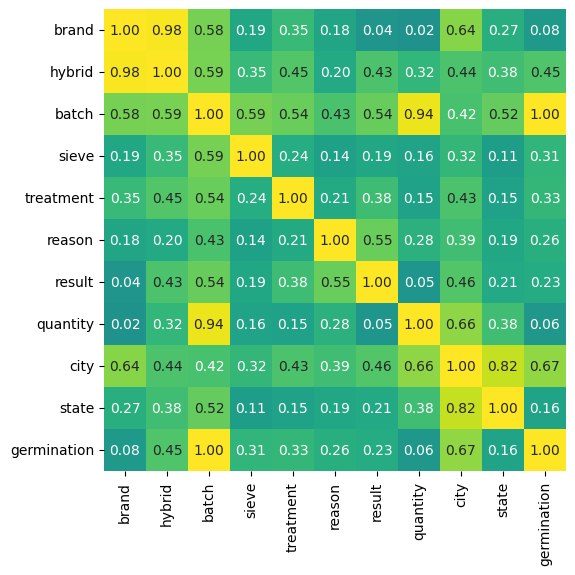

In [59]:
# Calculate the Cramer's V statistic
cramers_v = associations(df, figsize=(6, 6), cbar=False, cmap="viridis")

In [60]:
# Get the sorted associations
df_associations = pd.DataFrame(cramers_v["corr"])
sorted_associations = pd.DataFrame(
    df_associations["result"].sort_values(ascending=False)[1:]
)

fig = px.bar(
    sorted_associations,
    y="result",
    x=sorted_associations.index,
    color="result",
    color_continuous_scale="viridis",
    title="Ranked Associations with Result Variable",
)

# Show the plot
fig.show()

## Model

In [ ]:
X = df.drop('result', axis=1)
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)